# Setup: Libraries, Functions, and Data Loading

## Libraries

In [47]:
# Standard Imports
#%pip install nltk

import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

import requests

import matplotlib.pyplot as plt
import seaborn as sns
import re

In [48]:
# Only required on the first run
#nltk.download('vader_lexicon')
#nltk.download('punkt', force=True)
#nltk.download('punkt_tab')

## Functions

In [49]:
import re

def cut_at_anchor(raw_text, anchor):
    # remove HTML first
    clean = re.sub(r'<[^>]+>', '', raw_text)

    # normalize whitespace
    clean = re.sub(r'\s+', ' ', clean)

    # search for chapter heading
    m = re.search(re.escape(anchor), clean)
    if m:
        return clean[m.start():]

    print("Anchor not found!")
    return clean



In [50]:
# Instantiate our analyzer
sid = SentimentIntensityAnalyzer()

## Sourcing Raw Text

In [51]:
frank31 = requests.get('https://www.gutenberg.org/cache/epub/84/pg84-images.html').text

In [52]:
frank18 = requests.get('https://www.gutenberg.org/files/41445/41445-h/41445-h.htm').text

# Initial EDA

In [53]:
len(frank31)

465737

In [54]:
len(frank18)

430075

At this point, we need to consider some additional cleaning steps. The text retrieved from Project Gutenberg contains a lot of extraneous information, such as the Project Gutenberg header and footer, which we need to remove before performing sentiment analysis. We also have other artifacts such as //r//n line breaks, ’\\r\\n</p>\\r\\n\\r\\n<p>\\r\\n

In [55]:
frank31_count_r = len(re.findall(r'\r', frank31))
frank31_count_n = len(re.findall(r'\n', frank31))
frank31_count_p_tags = len(re.findall(r'</?p>', frank31))

print(f"Carriage returns (\\r): {frank31_count_r}")
print(f"Newlines (\\n): {frank31_count_n}")
print(f"<p> or </p> tags: {frank31_count_p_tags}")

Carriage returns (\r): 9006
Newlines (\n): 9006
<p> or </p> tags: 1497


In [56]:
frank18_count_r = len(re.findall(r'\r', frank18))
frank18_count_n = len(re.findall(r'\n', frank18))
frank18_count_p_tags = len(re.findall(r'</?p>', frank18))

print(f"Carriage returns (\\r): {frank18_count_r}")
print(f"Newlines (\\n): {frank18_count_n}")
print(f"<p> or </p> tags: {frank18_count_p_tags}")

Carriage returns (\r): 7378
Newlines (\n): 7378
<p> or </p> tags: 1526


# Cleaning + Tokenizing Text

## Cleaning

In [57]:
# Remove carriage returns and newlines
frank31_clean = re.sub(r'[\r\n]+', ' ', frank31)
frank18_clean = re.sub(r'[\r\n]+', ' ', frank18)

# Optionally remove HTML paragraph artifacts
frank31_clean = re.sub(r'</?p>', '', frank31_clean)
frank18_clean = re.sub(r'</?p>', '', frank18_clean)


# Print a short preview and some basic info to avoid dumping the entire HTML
print("frank31_clean preview:", frank31_clean[:500].strip())
print("frank31_clean length:", len(frank31_clean))
print("frank18_clean length:", len(frank18_clean))

frank31_clean preview: <!DOCTYPE html> <html lang="en"><head> <meta charset="utf-8"><style> #pg-header div, #pg-footer div {     all: initial;     display: block;     margin-top: 1em;     margin-bottom: 1em;     margin-left: 2em; } #pg-footer div.agate {     font-size: 90%;     margin-top: 0;     margin-bottom: 0;     text-align: center; } #pg-footer li {     all: initial;     display: block;     margin-top: 1em;     margin-bottom: 1em;     text-indent: -0.6em; } #pg-footer div.secthead {     font-size: 110%;     font
frank31_clean length: 450580
frank18_clean length: 416349


In [58]:
# This gets rid of the html docstring 
frank31_clean = re.sub(r'<[^>]+>', '', frank31_clean),
frank18_clean = re.sub(r'<[^>]+>', '', frank18_clean),

In [59]:
frank18_clean = cut_at_anchor(frank18, "I am by birth a Genevese; and my family is one of the most distinguished of that republic.")

In [60]:
frank31_clean = cut_at_anchor(frank31, " and my family is one of the most distinguished of that republic.")

#for currently unknown reasons, "I am by birth..." does not get recognized. I will for now continue as the impact of this error is low.

## Tokenizing

For this section, we are tokenizing the text so that they may be recognized by the sentiment analysis.

### for 1831 text

In [61]:
sentence_lev_sent_31 =[]

for s in sent_tokenize(frank31_clean):
    sentence_lev_sent_31.append(sid.polarity_scores(s)['compound'])

In [62]:
sentence_lev_df_31 = pd.DataFrame(
    {'Sentence_31': sent_tokenize(frank31_clean),
     'Sentiment_31': sentence_lev_sent_31}
)

sentence_lev_df_31['Sentiment_Smooth31'] = sentence_lev_df_31['Sentiment_31'].rolling(30).mean()

sentence_lev_df_31.sample(5)

,Sentence_31,Sentiment_31,Sentiment_Smooth31
712,The servant instantly showed it to one of the ...,0.0000,-0.055750
1918,"I enjoyed this scene, and yet my enjoyment was...",0.7845,0.269720
189,She devoted herself to those whom she had been...,0.4019,-0.047637
571,"The evening was warm and serene, and we prolon...",0.5994,0.401723
2526,"How did I cling to their dear forms, as someti...",-0.2003,-0.024737


In [63]:
sentence_lev_df_31['Sentiment_Smooth31'].isnull().sum()

np.int64(29)

The null values can be explained due to the value chosen for rolling mean which is 30, so the first 29 values will be NaN.

In [64]:
sentence_lev_df_31['Sentence_31']

0        and my family is one of the most distinguishe...
1       My ancestors had been for many years counsello...
2       He was respected by all who knew him for his i...
3       He passed his younger days perpetually occupie...
4       As the circumstances of his marriage illustrat...
                              ...                        
2975    For forty years, he produced and distributed P...
2976    Project Gutenberg™ eBooks are often created fr...
2977    Thus, we do not necessarily keep eBooks in com...
2978    Most people start at our website which has the...
2979    This website includes information about Projec...
Name: Sentence_31, Length: 2980, dtype: object

### For 1818 Text

In [65]:
sentence_lev_sent_18 =[]

for s in sent_tokenize(frank18_clean):
    sentence_lev_sent_18.append(sid.polarity_scores(s)['compound'])

In [66]:
sentence_lev_df_18 = pd.DataFrame(
    {'Sentence_18': sent_tokenize(frank18_clean),
     'Sentiment_18': sentence_lev_sent_18}
)

sentence_lev_df_18['Sentiment_Smooth18'] = sentence_lev_df_18['Sentiment_18'].rolling(30).mean()

sentence_lev_df_18.sample(5)

,Sentence_18,Sentiment_18,Sentiment_Smooth18
1554,"A few incidents now and then directed me, and ...",0.0000,-0.181803
2673,I pitied Frankenstein; my pity amounted to hor...,-0.8910,-0.245647
1487,I was like a wild beast that had broken the to...,-0.6369,-0.007363
2498,"learn my miseries, and do not seek to increase...",-0.5316,-0.078610
458,M. Krempe was not equally docile; and in my co...,-0.4201,0.207007


In [67]:
sentence_lev_df_18['Sentiment_Smooth18'].isnull().sum()

np.int64(29)

# Unifying Dataframes

In [68]:

df = sentence_lev_df_18.merge(
    sentence_lev_df_31,
    left_index=True,
    right_index=True,
    how='outer',
    suffixes=('_18', '_31')
)
print("df shape:", df.shape)

df shape: (2980, 6)


In [69]:
df.sample(5)

,Sentence_18,Sentiment_18,Sentiment_Smooth18,Sentence_31,Sentiment_31,Sentiment_Smooth31
2068,As the images that floated before me became mo...,0.8834,-0.218160,Between two and three in the morning the moon ...,0.0258,-0.025397
625,Poor Elizabeth also is quite inconsolable.â ...,-0.7783,-0.029723,I wept like a child.,-0.1280,-0.036040
1664,"Depart to your home, and commence your labours...",-0.3818,0.064470,"Suddenly, as I gazed on him, an idea seized me...",-0.5719,-0.038327
2941,NaN,NaN,NaN,1.F.4.,0.0000,-0.080110
1573,"Inflamed by pain, I vowed eternal hatred and v...",-0.8720,0.005640,No: from that moment I declared everlasting wa...,-0.8689,-0.219477


In [70]:
df.head(10) # change this value to > 35 to see changes in sentiment smooth variables

,Sentence_18,Sentiment_18,Sentiment_Smooth18,Sentence_31,Sentiment_31,Sentiment_Smooth31
0,I am by birth a Genevese; and my family is one...,0.0000,NaN,and my family is one of the most distinguishe...,0.0000,NaN
1,My ancestors had been for many years counsello...,0.5719,NaN,My ancestors had been for many years counsello...,0.5719,NaN
2,He was respected by all who knew him for his i...,0.6908,NaN,He was respected by all who knew him for his i...,0.6908,NaN
3,He passed his younger days perpetually occupie...,0.3612,NaN,He passed his younger days perpetually occupie...,0.0258,NaN
4,As the circumstances of his marriage illustrat...,0.0000,NaN,As the circumstances of his marriage illustrat...,0.0000,NaN
5,One of his most intimate friends was a merchan...,0.0202,NaN,One of his most intimate friends was a merchan...,0.0202,NaN
6,"This man, whose name was Beaufort, was of a pr...",0.4939,NaN,"This man, whose name was Beaufort, was of a pr...",0.4939,NaN
7,"Having paid his debts, therefore, in the most ...",0.5256,NaN,"Having paid his debts, therefore, in the most ...",0.5256,NaN
8,My father loved Beaufort with the truest frien...,0.6378,NaN,My father loved Beaufort with the truest frien...,0.6378,NaN
9,"He grieved also for the loss of his society, a...",-0.2500,NaN,He bitterly deplored the false pride which led...,0.8930,NaN


By this point, we have the rolling mean sentiment scores for both versions of Frankenstein. As we can see, by index value 9, the datasets diverge.

# First Visual Analysis

<Axes: ylabel='Sentiment_Smooth31'>

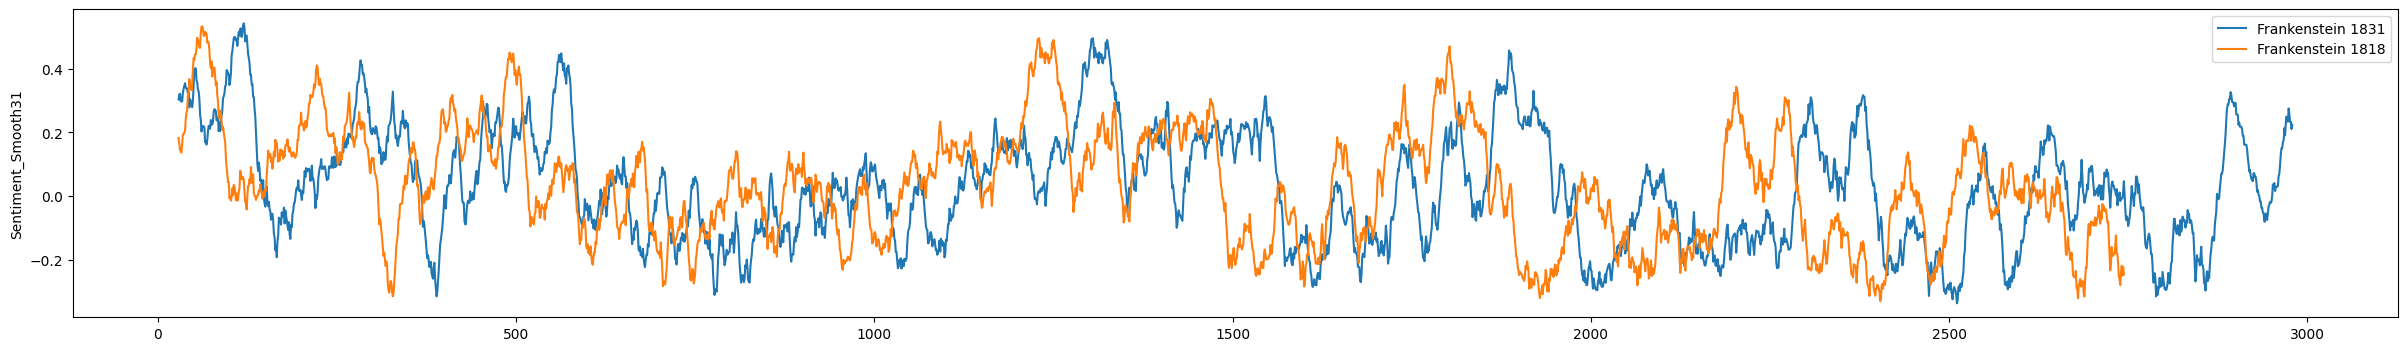

In [71]:
rough_graph = plt.figure(figsize=(30, 4))
sns.lineplot(x=df.index.to_list(), y='Sentiment_Smooth31', data=df, label = 'Frankenstein 1831')
sns.lineplot(x=df.index.to_list(), y='Sentiment_Smooth18', data=df, label = 'Frankenstein 1818')


In [72]:
print(f"The overall difference in book length is {len(frank18_clean) - len(frank31_clean)}")

The overall difference in book length is -27594


Notice how 1831 version is longer than the 1818 version. This is very much the expected outcome of comparing two different books. In order to solve this issue, we can impute or randomly drop values from either the minority or majority class variable respectively. We will do both methods and compare for reliability.

# Solution 1: Randomly Dropping Values in 1831

In [73]:
df.sample(3)

,Sentence_18,Sentiment_18,Sentiment_Smooth18,Sentence_31,Sentiment_31,Sentiment_Smooth31
946,"and, oh, that I could, with the extinction of ...",-0.5562,-0.041683,I performed the first part of my journey on ho...,0.0000,0.055437
1936,"Your hours will pass in dread and misery, and ...",-0.4767,-0.273193,"“I could pass my life here,” said he to me; “a...",-0.2967,0.196863
1637,Let me see that I excite the sympathy of some ...,0.7862,-0.010317,"I felt emotions of gentleness and pleasure, th...",0.2023,-0.109467


In [74]:
df_dropped = pd.DataFrame(
    df['Sentiment_Smooth31']
)

In [75]:
df_temp_18 = pd.DataFrame(
    df['Sentiment_Smooth18']
).dropna()

In [76]:
len(df_temp_18)

2716

In [77]:
len(df_dropped)

2980

In [78]:
df_dropped = df_dropped.sample(n=df_temp_18.shape[0]).sort_index().reset_index(drop=True)

len(df_dropped)

2716

In [79]:
df_dropped.shape

(2716, 1)

In [80]:
print(
    len(df['Sentence_18']),
    df['Sentence_18'].isnull().sum()
)

2980 235


In [81]:
print(
    len(df['Sentence_31']),
    df['Sentence_31'].isnull().sum()
)

2980 0


<Axes: ylabel='Sentiment_Smooth31'>

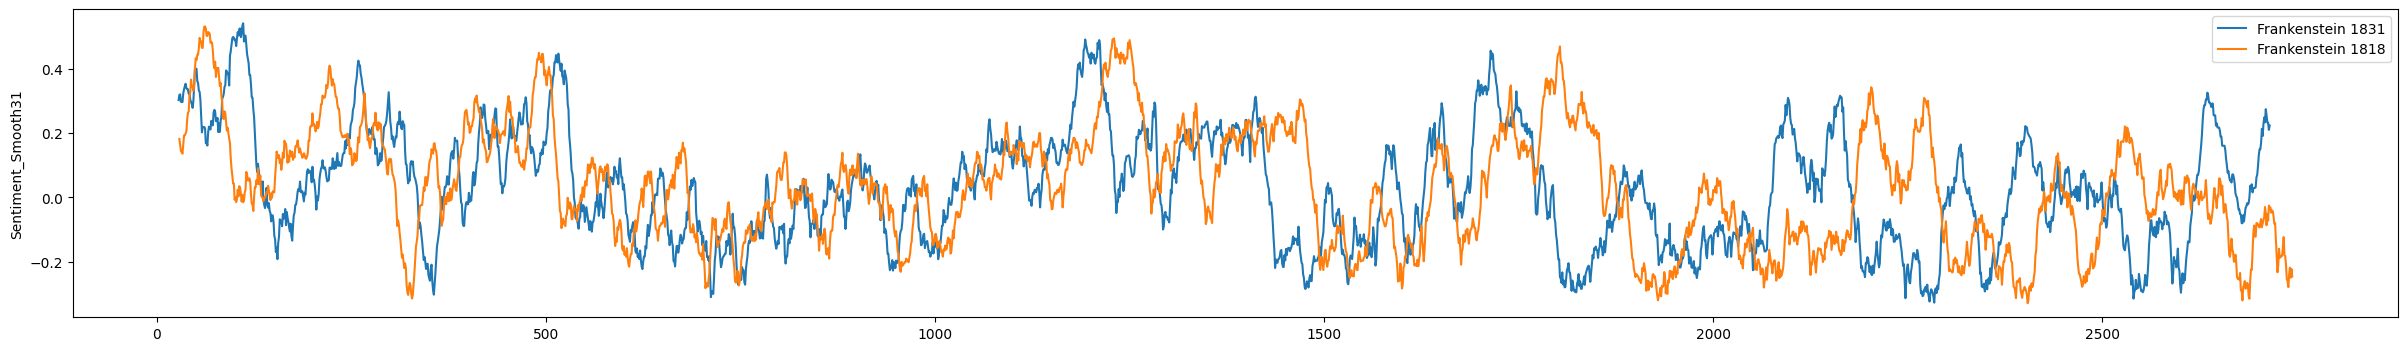

In [82]:
dropped_graph = plt.figure(figsize=(30, 4))
sns.lineplot(x=df_dropped.index.to_list(), y='Sentiment_Smooth31', data=df_dropped, label = 'Frankenstein 1831')
sns.lineplot(x=df.index.to_list(), y='Sentiment_Smooth18', data=df, label = 'Frankenstein 1818')

# Solution 2: Imputing new values in 1818

The method to perform this operation will be to get a scale factor by which to increase the length of the 1818 text to. This will be done by dividing the length of the 1831 text by the length of the 1818 text.

In [83]:

frank31_len = len(sent_tokenize(frank31_clean))
frank18_len = len(sent_tokenize(frank18_clean))

print(f"The length of the 1831 edition is {frank31_len} and the length of the 1818 edition is {frank18_len}")

The length of the 1831 edition is 2980 and the length of the 1818 edition is 2745


In [84]:
scale_factor = 2980 / 2745
scale_factor

1.0856102003642987

In [85]:
df_impute = pd.DataFrame(
    df['Sentiment_Smooth18']

)

In [86]:
new_index = df_impute.index.to_list()

In [87]:
new_index = [int(i * scale_factor) for i in new_index]

In [88]:
df_impute.index = new_index
df_impute

,Sentiment_Smooth18
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
3229,NaN
3230,NaN
3231,NaN
3232,NaN


<Axes: ylabel='Sentiment_Smooth31'>

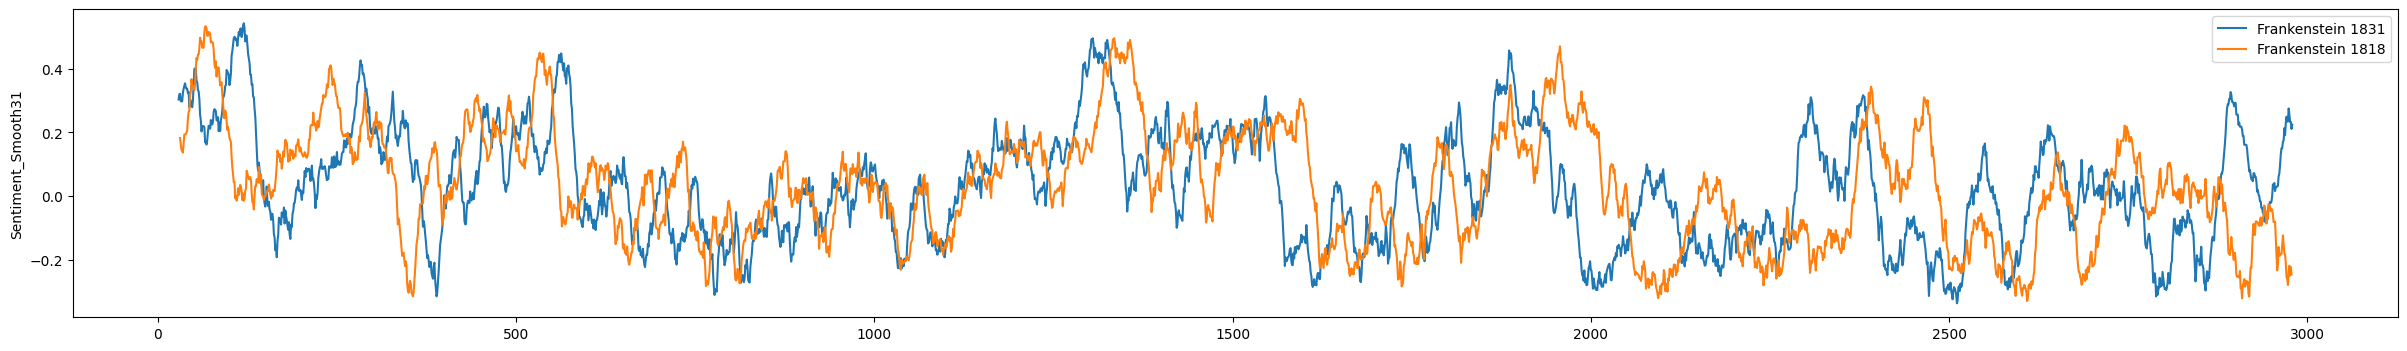

In [89]:
imputed_graph = plt.figure(figsize=(30, 4))
sns.lineplot(x=df.index.to_list(), y='Sentiment_Smooth31', data=df, label = 'Frankenstein 1831')
sns.lineplot(x=df_impute.index.to_list(), y='Sentiment_Smooth18', data=df_impute, label = 'Frankenstein 1818')

# All Graphs


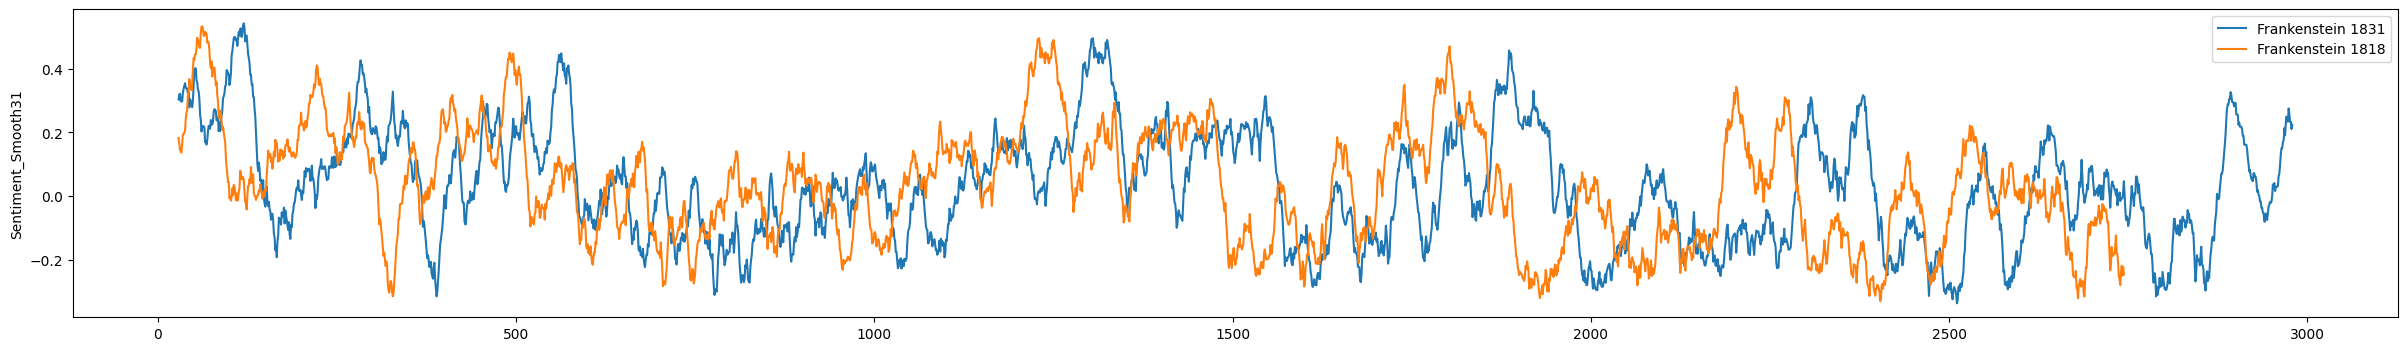

In [91]:
rough_graph

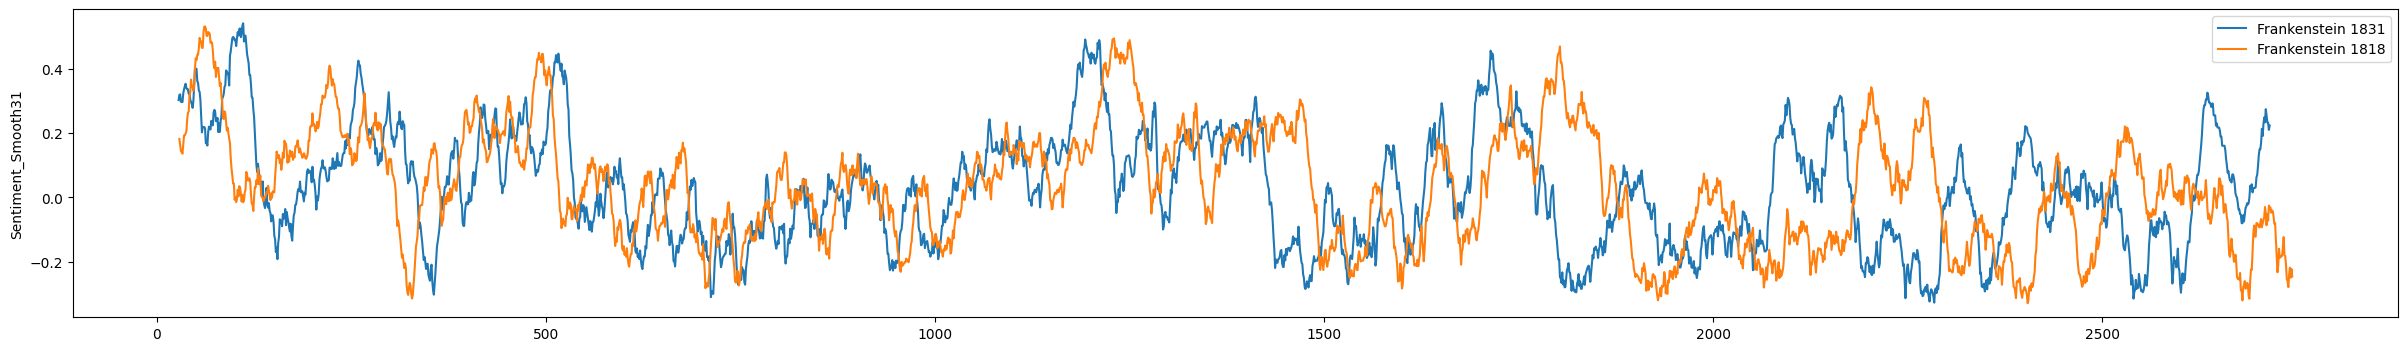

In [92]:
dropped_graph

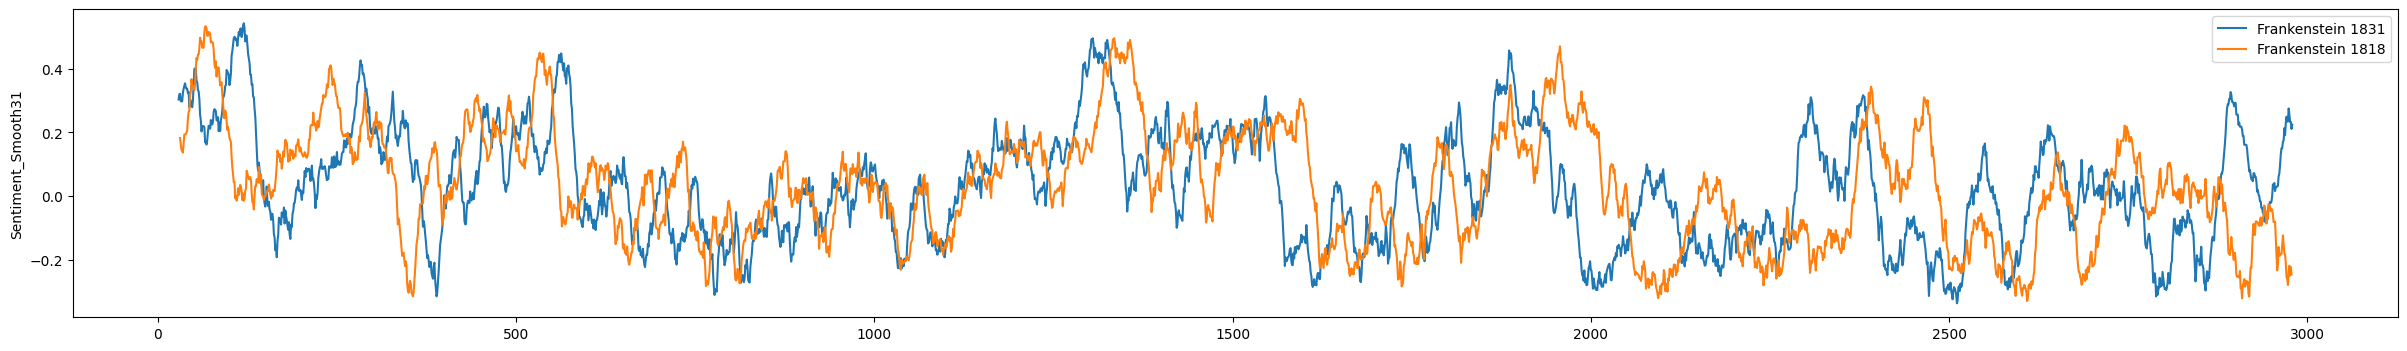

In [93]:
imputed_graph

# Discussion

Overall, both methods of balancing the datasets produced similar results. There are some differences in the peaks and valleys of the sentiment scores, but the overall trends are consistent across both methods. This suggests that our findings are robust to the method of balancing used. Additional indicators of reliability would be the near perfect matchup of both smoothed sentiment lines at around the 1000 mark on the imputed graph.

In my own opinion, the expansion of the 1818 text through imputation seems to have produced a better result than the random dropped graph. While accounting for the variance between comparisons, the imputed graph seems to have a closer alignment of peaks and valleys between the two texts. 

Additionally the results have an interesting literary implication. In the 1818 text, the stronger peaks in sentiment tend to occur earlier than the 1831 peaks until around the halfway mark where it switches after syncing up near the 1000 mark. The patterns in the data may indicate that overall, both editions share the same sentiment patterns at roughly the same times, however, the degree to which sentiment differs in some areas are interesting to point out. Take the 1500 - 2000 range for instance, where the sentiment context is certainly present in both texts however the height of peaks vary more. The starkest difference to note is the ending where the contextual sentiment overlap splits dramatically. This may indicate that the changes made in the 1831 edition altered the tone of the ending significantly compared to the original 1818 text. This could be a point of further literary analysis to explore how the revisions impacted the overall sentiment and themes of the novel's conclusion.

This analysis demonstrates how NLP techniques can be applied to literary texts to uncover insights about authorial revisions and their effects on narrative tone. By quantitatively comparing sentiment across different editions, we can gain a deeper understanding of how changes in language reflect shifts in thematic emphasis and emotional impact. This approach demonstrates the potential of computational methods to enhance the traditional study of literature.